In [183]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [184]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [185]:
NUM_CLASSES = 8

# Dataset reading

In [186]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [187]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [189]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [190]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_18 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                860       
_________________________________________________________________
dropout_19 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 88        
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [191]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [192]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [193]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
32/32 [==============================] - 0s 6ms/step - loss: 2.0859 - accuracy: 0.1966 - val_loss: 1.9111 - val_accuracy: 0.2526

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.8975 - accuracy: 0.2730 - val_loss: 1.7680 - val_accuracy: 0.2541

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.7579 - accuracy: 0.3067 - val_loss: 1.6327 - val_accuracy: 0.4741

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.6571 - accuracy: 0.3508 - val_loss: 1.4987 - val_accuracy: 0.5163

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 1.5587 - accuracy: 0.3974 - val_lo

In [194]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

 1/11 [=>............................] - ETA: 0s - loss: 0.3812 - accuracy: 0.9453

11/11 [==============================] - 0s 1ms/step - loss: 0.3400 - accuracy: 0.9304


In [195]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [196]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[7.0533447e-02 4.3624067e-01 4.6905455e-01 5.5653155e-03 3.3129537e-03
 6.9846674e-03 8.1667295e-03 1.4163638e-04]
2


# Confusion matrix

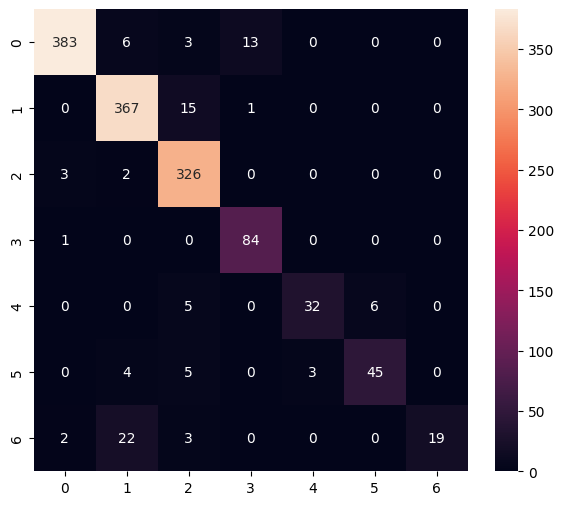

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       405
           1       0.92      0.96      0.94       383
           2       0.91      0.98      0.95       331
           3       0.86      0.99      0.92        85
           4       0.91      0.74      0.82        43
           5       0.88      0.79      0.83        57
           6       1.00      0.41      0.58        46

    accuracy                           0.93      1350
   macro avg       0.92      0.83      0.86      1350
weighted avg       0.93      0.93      0.93      1350



In [197]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [198]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [199]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp56kaopwz\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp56kaopwz\assets


6592

# Inference test

In [200]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [201]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [202]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [203]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [204]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.0533440e-02 4.3624082e-01 4.6905449e-01 5.5653197e-03 3.3129596e-03
 6.9846800e-03 8.1667323e-03 1.4163637e-04]
2
